# Rain Prediction using Bayesian Networks

Adding imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.inference import ApproxInference
from pgmpy.inference import BeliefPropagation
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score
from pgmpy.metrics import log_likelihood_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import networkx as nx
import time
import gradio as gr
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version.*")

#dataset:https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data

INFO:httpx:HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"


## Reading and preprocessing the dataset

In [2]:
# Load the dataset
df = pd.read_csv('weatherAUS.csv')
print(df.head())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

At a first glance we see the columns Location and Date. We want a robust prediction model that is not influenced by the location or the date of the measurement.
We will proceed to eliminate these 2 columns.

In [3]:
df = df.drop('Location', axis=1)
df = df.drop('Date', axis=1)
print(df.head())

   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0     13.4     22.9       0.6          NaN       NaN           W   
1      7.4     25.1       0.0          NaN       NaN         WNW   
2     12.9     25.7       0.0          NaN       NaN         WSW   
3      9.2     28.0       0.0          NaN       NaN          NE   
4     17.5     32.3       1.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity9am  \
0           44.0          W        WNW          20.0  ...         71.0   
1           44.0        NNW        WSW           4.0  ...         44.0   
2           46.0          W        WSW          19.0  ...         38.0   
3           24.0         SE          E          11.0  ...         45.0   
4           41.0        ENE         NW           7.0  ...         82.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         22.0       1007.7       1007.1       8.0       NaN     16.9   


Next, we will check every column of the dataset for null values.

In [4]:
# Check for null values
def check_for_null(df):
    print(f"\nChecking the dataset for null values")
    print(f"Current shape of dataframe: {df.shape}")
    for col in df.columns:
        if np.sum(df[col].isna()) > 0:
            print(f"The number of nan/null columns for the column: {col} is {np.sum(df[col].isna())} na values"
                  f"\n and has {np.sum(df[col].isnull())} null ")

check_for_null(df)


Checking the dataset for null values
Current shape of dataframe: (145460, 21)
The number of nan/null columns for the column: MinTemp is 1485 na values
 and has 1485 null 
The number of nan/null columns for the column: MaxTemp is 1261 na values
 and has 1261 null 
The number of nan/null columns for the column: Rainfall is 3261 na values
 and has 3261 null 
The number of nan/null columns for the column: Evaporation is 62790 na values
 and has 62790 null 
The number of nan/null columns for the column: Sunshine is 69835 na values
 and has 69835 null 
The number of nan/null columns for the column: WindGustDir is 10326 na values
 and has 10326 null 
The number of nan/null columns for the column: WindGustSpeed is 10263 na values
 and has 10263 null 
The number of nan/null columns for the column: WindDir9am is 10566 na values
 and has 10566 null 
The number of nan/null columns for the column: WindDir3pm is 4228 na values
 and has 4228 null 
The number of nan/null columns for the column: WindS

Upon checking the number of null values, we can see that some columns have over 50000 missing values, with the dataset having 145460 values.
The columns in this situation are: ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']. 
Given how impredictible the weather features can be, there is no reliable method to infer the missing values without potentially harming the performance of the model. This is even more so, as we would need to fill in more than a third of of the data for each particular column.
Given this, we will choose to drop the beforementioned features.

In [5]:
columns_to_drop = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Check for any remaining NaN values in the dataset
print(df.isnull().sum())

MinTemp           1485
MaxTemp           1261
Rainfall          3261
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


While we got rid of the columns have huge amounts of data(up to one third) missing, we still have columns that have missing values, but in smaller quantities.
Given that the dataset has a huge number of datapoints compared to the number of missing values per column, we will try to drop the rows that have one or more missing values.

In [6]:
# Next, We will drop the rows that have null values.
def drop_null(df):
    print(f"Current shape of dataframe: {df.shape}")
    # Drop rows with any NaN values
    df_clean = df.dropna()
    print(f"\nNew shape of dataframe after dropping rows with any NaN values: {df_clean.shape}")
    return df_clean

df = drop_null(df)
check_for_null(df)

Current shape of dataframe: (145460, 17)

New shape of dataframe after dropping rows with any NaN values: (112925, 17)

Checking the dataset for null values
Current shape of dataframe: (112925, 17)


While this approach might not be ideal in certain scenarios, with this approach we managed to maintain more than 75% of the data.
Further more, this approach is straightforward, and eliminates the risk of inducing noise/ outliers that would appear if we would try to approximate the missing data.

### Checking the dataset for possible data insights/ dataset imbalances

For this, we need to transform the non numeric values into numerical, categorical data.
We will do this using the LabelEncoder functionality.

In [7]:
non_numeric_columns = df.select_dtypes(include=['object']).columns
print(f"The non-numeric columns in our dataset are: {non_numeric_columns}")
encoded_df = df.copy()
label_encoder = LabelEncoder()
for column in non_numeric_columns:
    encoded_df[column] = encoded_df[column].fillna('Missing')
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

print(encoded_df.head())


The non-numeric columns in our dataset are: Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')
   MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
0     13.4     22.9       0.6           13           44.0          13   
1      7.4     25.1       0.0           14           44.0           6   
2     12.9     25.7       0.0           15           46.0          13   
3      9.2     28.0       0.0            4           24.0           9   
4     17.5     32.3       1.0           13           41.0           1   

   WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          14          20.0          24.0         71.0         22.0   
1          15           4.0          22.0         44.0         25.0   
2          15          19.0          26.0         38.0         30.0   
3           0          11.0           9.0         45.0         16.0   
4           7           7.0          20.0         82.0         33.



Lets investigate the correlation between the features and the target variable(RainTommorow)

In [8]:
correlation_matrix = encoded_df.corr()

# Isolate the correlations with 'RainTomorrow'
correlation_with_rain_tomorrow = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

print(correlation_with_rain_tomorrow)

RainTomorrow     1.000000
Humidity3pm      0.455945
RainToday        0.315359
Humidity9am      0.276704
WindGustSpeed    0.238664
Rainfall         0.238379
WindSpeed3pm     0.096277
WindSpeed9am     0.093173
MinTemp          0.078691
WindGustDir      0.051767
WindDir9am       0.029832
WindDir3pm       0.026099
Temp9am         -0.035385
MaxTemp         -0.168872
Temp3pm         -0.203525
Pressure3pm     -0.224142
Pressure9am     -0.243702
Name: RainTomorrow, dtype: float64


Next, let's explore the distribution of the features

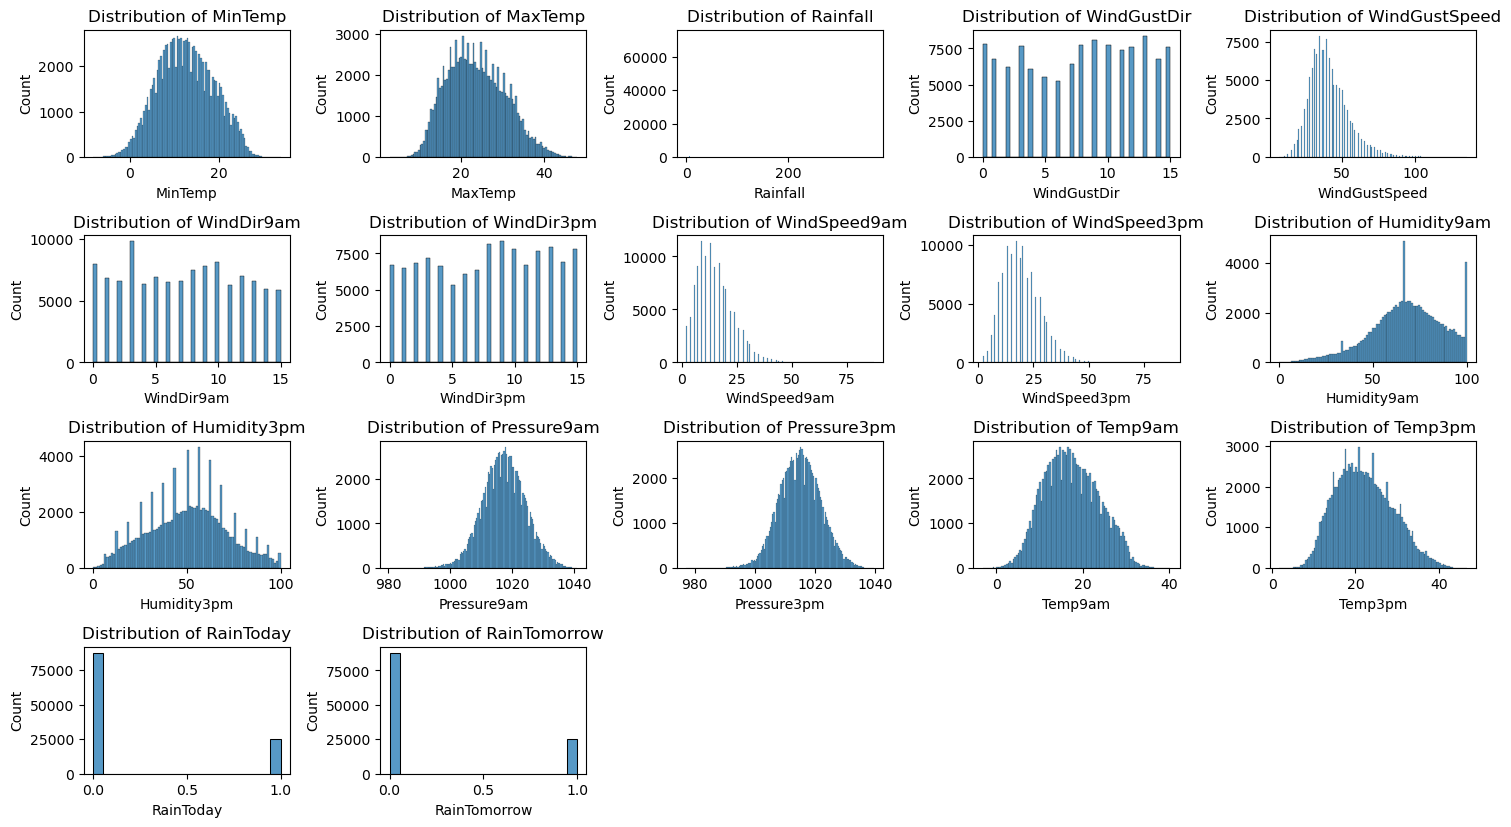

In [9]:
variables = df.columns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Loop through the variables and create a subplot for each distribution
for i, var in enumerate(variables):
    plt.subplot(5, 5, i + 1)
    sns.histplot(encoded_df[var], kde=False)
    plt.title(f'Distribution of {var}')
    plt.tight_layout()

plt.show()

The most important thing to note in the previous plots is the imbalance in the RainTommorow class.
As this is the class that we want to predict, such a big imbalance between the two classes may cause problems.
Many methods can be employed to solve this problem, such as undersampling the majority class, or to oversample the minority class.
A short analysis of our case tells us that the first option is the best.
Reasons: The minority class is 3 times less populated than the majority class, and the minority class, even if its unrepresented, it still has around 20000 datapoints.
By undersampling the majority class, we will still have around 40000 datapoints.
Mentions: some data insight and trends might be lost, but by balancing the 2 classes the model will not overfit on the majority class.

## Balancing the predicted class

In [10]:
majority = encoded_df[encoded_df.RainTomorrow == 0]
minority = encoded_df[encoded_df.RainTomorrow == 1]

# Downsample majority class
majority_downsampled = resample(majority,
                                replace=False,    # sample without replacement
                                n_samples=len(minority),  
                                random_state=42)  # reproducible results

# Combining minority class with downsampled majority class
balanced_df = pd.concat([majority_downsampled, minority])

# Shuffling the dataset to mix up the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution of 'RainTomorrow'
print(balanced_df.RainTomorrow.value_counts())

RainTomorrow
1    25019
0    25019
Name: count, dtype: int64


### Lastly we will check one again the distribution of data and the correlation between the target class and the features


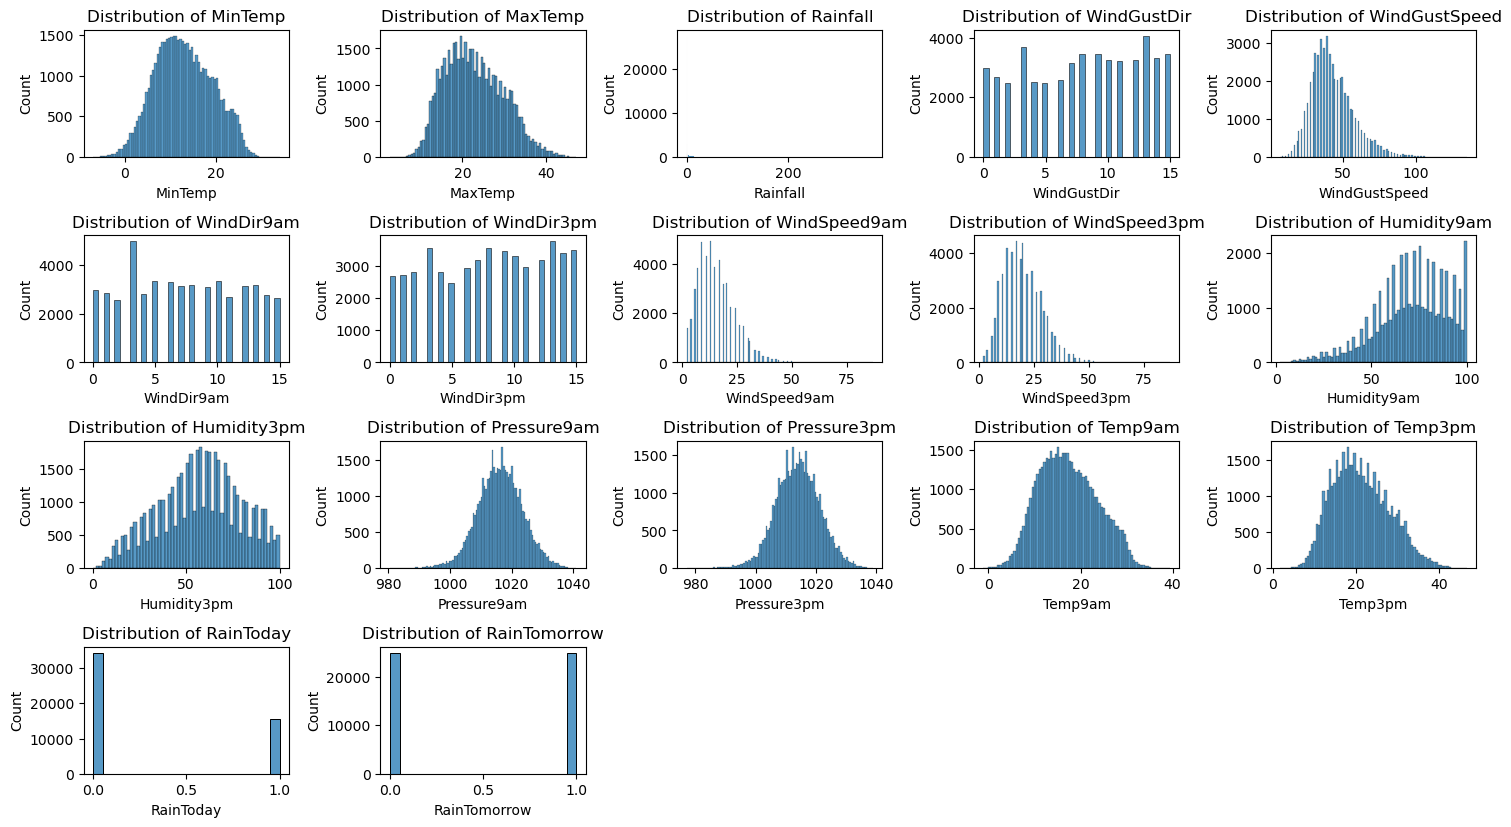

In [11]:
variables = balanced_df.columns

plt.figure(figsize=(15, 10))

# Loop through the variables and create a subplot for each distribution
for i, var in enumerate(variables):
    plt.subplot(5, 5, i + 1)  
    sns.histplot(balanced_df[var], kde=False)
    plt.title(f'Distribution of {var}')
    plt.tight_layout()

plt.show()

In [12]:
correlation_matrix = balanced_df.corr()

# Isolate the correlations with 'RainTomorrow'
correlation_with_rain_tomorrow = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

print(correlation_with_rain_tomorrow)

RainTomorrow     1.000000
Humidity3pm      0.523106
RainToday        0.341747
Humidity9am      0.340459
WindGustSpeed    0.266316
Rainfall         0.217551
WindSpeed3pm     0.112355
WindSpeed9am     0.107904
MinTemp          0.099237
WindGustDir      0.057973
WindDir9am       0.036703
WindDir3pm       0.028702
Temp9am         -0.038777
MaxTemp         -0.202375
Temp3pm         -0.243537
Pressure3pm     -0.259273
Pressure9am     -0.280975
Name: RainTomorrow, dtype: float64


In [13]:
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


### Having the dataset prepared, we will evaluate the performance of the dataset on a decision tree clasifier.

We are doing this to establish a potential baseline for our future experiments

A quick overview of the process is:
1. Splitting the data into the train and test splits.
2. Using GridSearchCV to do a grid search in order to ensure that the hyperparameter of the model is decently chosen.

In [14]:
X = balanced_df.drop('RainTomorrow', axis = 1)
y = balanced_df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"The size of X is {X.shape} and of y is {y.shape}")
print(f"The train size of X is {X_train.shape} and of y is {y_train.shape}")
print(f"The train size of X is {X_test.shape} and of y is {y_test.shape}")

The size of X is (50038, 16) and of y is (50038,)
The train size of X is (37528, 16) and of y is (37528,)
The train size of X is (12510, 16) and of y is (12510,)


In [15]:
max_depth_range = range(1, 20, 2)
param_grid = {'max_depth': max_depth_range}

# Setup grid search with cross-validation for DecisionTree
dt = DecisionTreeClassifier(random_state=42)
grid_search= GridSearchCV(dt, param_grid, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(1, 20, 2)}, return_train_score=True,
             scoring='accuracy')

In [16]:
# the best dt is:
best_params = grid_search.best_params_
ideal_depth = best_params['max_depth']
print(f"The ideal max_depth is: {ideal_depth}")
best_dt = DecisionTreeClassifier(max_depth=ideal_depth, random_state=42)
best_dt.fit(X_train, y_train)

# Predictions on the test set
y_pred = best_dt.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

The ideal max_depth is: 5
Accuracy on test set: 0.7636290967226219


### Next, we will prepare the data in order to use it for our Bayesian Network architectures

In [17]:
print(balanced_df.head())

   MinTemp  MaxTemp  Rainfall  WindGustDir  WindGustSpeed  WindDir9am  \
0      9.9     13.1       0.6           13           93.0           3   
1     13.2     18.6       4.2            9           59.0           9   
2      8.5     16.4       0.2           13           35.0           3   
3      7.8     21.6       0.0           10           39.0          13   
4     11.2     15.7       1.0            3           33.0           3   

   WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          13          26.0          35.0         66.0         57.0   
1           9          31.0          35.0         67.0         68.0   
2          14           7.0          11.0         85.0         73.0   
3           8          17.0          15.0         69.0         46.0   
4           3          11.0          17.0         78.0         73.0   

   Pressure9am  Pressure3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  
0       1004.3       1007.2     12.8     12.0          0     

In [18]:
# We will check again the correlation matrix
correlation_matrix = balanced_df.corr()

# Isolate the correlations with 'RainTomorrow'
correlation_with_rain_tomorrow = correlation_matrix['RainTomorrow'].apply(abs).sort_values(ascending=False)

print(correlation_with_rain_tomorrow)

RainTomorrow     1.000000
Humidity3pm      0.523106
RainToday        0.341747
Humidity9am      0.340459
Pressure9am      0.280975
WindGustSpeed    0.266316
Pressure3pm      0.259273
Temp3pm          0.243537
Rainfall         0.217551
MaxTemp          0.202375
WindSpeed3pm     0.112355
WindSpeed9am     0.107904
MinTemp          0.099237
WindGustDir      0.057973
Temp9am          0.038777
WindDir9am       0.036703
WindDir3pm       0.028702
Name: RainTomorrow, dtype: float64


Here, we can see that some columns have low correlation with the predicting target RainTommorow
To simplify the process, we will try to reduce the number of variables that will be used in the design of the network, as their impact will most likely will be quite low

For instance, The WindDirection parameters are related to the location where the data was taken from. As the location column was dropped, it only makes sense to drop the WindDir columns(WindDir9am, WindDir3pm, WindGustDir)

Additionally, for now, we will set a cutoff correlation of 0.1, as the model has quite alot of features, and the return of using features with low correlation will be small => we will also exclude the features Temp9am and MinTemp.

In [19]:
columns_to_drop = ['WindDir9am', 'WindDir3pm', 'WindGustDir', 'Temp9am', 'MinTemp', 'Temp3pm']
balanced_df = balanced_df.drop(columns=columns_to_drop, axis = 1)

# Display the updated DataFrame to confirm columns have been dropped
print(balanced_df.head())

   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
0     13.1       0.6           93.0          26.0          35.0         66.0   
1     18.6       4.2           59.0          31.0          35.0         67.0   
2     16.4       0.2           35.0           7.0          11.0         85.0   
3     21.6       0.0           39.0          17.0          15.0         69.0   
4     15.7       1.0           33.0          11.0          17.0         78.0   

   Humidity3pm  Pressure9am  Pressure3pm  RainToday  RainTomorrow  
0         57.0       1004.3       1007.2          0             1  
1         68.0       1029.1       1027.3          1             1  
2         73.0       1027.0       1024.5          0             1  
3         46.0       1021.2       1021.7          0             0  
4         73.0       1025.3       1021.0          0             0  


### Discretize the data

First we will analyze the MaxTemp column, we will study the distribution of data and choose representative data intervals to discretize it

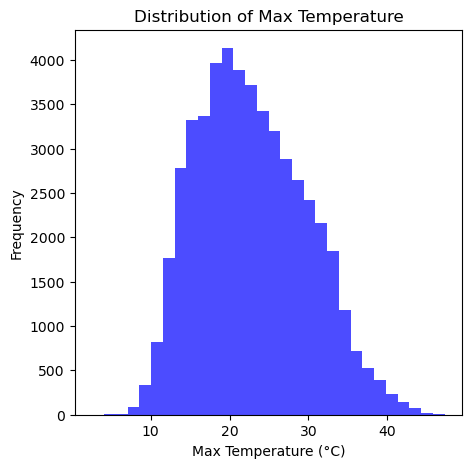

In [20]:
# Plotting the histogram for 'MaxTemp'
plt.figure(figsize=(5, 5))  
plt.hist(balanced_df['MaxTemp'].dropna(), bins=30, color='blue', alpha=0.7)  
plt.title('Distribution of Max Temperature')  
plt.xlabel('Max Temperature (°C)')  
plt.ylabel('Frequency')  

plt.show()

In [21]:
check_for_null(balanced_df)
# Define bins edges
bins = [-float('inf'), 10, 20, 30, 40, float('inf')]

# Define labels for each bin
labels = ['<10', '10-20', '20-30', '30-40', '>40']

balanced_df['MaxTemp_Categories'] = pd.cut(balanced_df['MaxTemp'], bins=bins, labels=labels, right=False)

print(balanced_df[['MaxTemp', 'MaxTemp_Categories']].head())

print(balanced_df['MaxTemp_Categories'].value_counts())

balanced_df = balanced_df.drop('MaxTemp', axis=1)

check_for_null(balanced_df)


Checking the dataset for null values
Current shape of dataframe: (50038, 11)
   MaxTemp MaxTemp_Categories
0     13.1              10-20
1     18.6              10-20
2     16.4              10-20
3     21.6              20-30
4     15.7              10-20
MaxTemp_Categories
20-30    21926
10-20    18797
30-40     8459
>40        444
<10        412
Name: count, dtype: int64

Checking the dataset for null values
Current shape of dataframe: (50038, 11)


The same methodology will be used for the rainfall column.

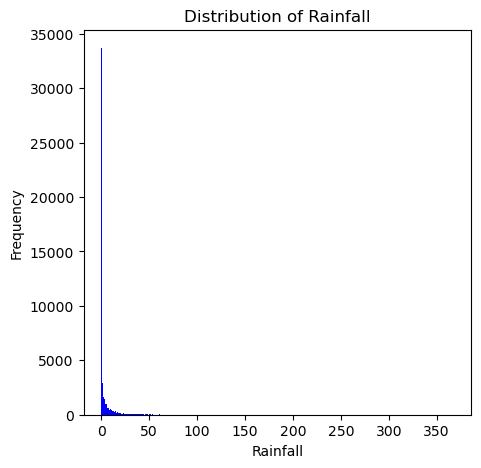

In [22]:
# Plotting the histogram for 'Rainfall'
plt.figure(figsize=(5, 5))  
plt.hist(balanced_df['Rainfall'], bins=400, color='blue')  
plt.title('Distribution of Rainfall')  
plt.xlabel('Rainfall')  
plt.ylabel('Frequency')  

plt.show()

In [23]:
bins = list(range(0, 21, 5)) + list(range(21, 42, 10)) + [float('inf')]

# Define labels for each bin
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-2)] + ['>40']

balanced_df['Rainfall_Categories'] = pd.cut(balanced_df['Rainfall'], bins=bins, labels=labels, right=False)

print(balanced_df[['Rainfall', 'Rainfall_Categories']].head())

print(balanced_df['Rainfall_Categories'].value_counts())

balanced_df = balanced_df.drop('Rainfall', axis=1)

   Rainfall Rainfall_Categories
0       0.6                 0-5
1       4.2                 0-5
2       0.2                 0-5
3       0.0                 0-5
4       1.0                 0-5
Rainfall_Categories
0-5      41122
5-10      3544
10-15     1816
15-20     1131
21-31      993
>40        782
31-41      506
20-21      144
Name: count, dtype: int64


For the columns regarding the speed of the wind, we will use the classification used at the following link to categorize the data
link: # https://www.rmets.org/metmatters/beaufort-wind-scale

In [24]:
# categorizing the windspeeds
wind_speed_bins = [-float('inf'), 15, 55, float('inf')]
wind_speed_labels = ['low', 'medium', 'strong']

# Convert the 'WindGustSpeed', 'WindSpeed9am', and 'WindSpeed3pm' columns to categorical
for column in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    balanced_df[column + '_Category'] = pd.cut(balanced_df[column], bins=wind_speed_bins, labels=wind_speed_labels, right=False)

print(balanced_df[['WindGustSpeed', 'WindGustSpeed_Category', 'WindSpeed9am', 'WindSpeed9am_Category', 
          'WindSpeed3pm', 'WindSpeed3pm_Category']].head())

for column in ['WindGustSpeed_Category', 'WindSpeed9am_Category', 'WindSpeed3pm_Category']:
    print(balanced_df[column].value_counts())

balanced_df = balanced_df.drop('WindGustSpeed', axis=1)
balanced_df = balanced_df.drop('WindSpeed9am', axis=1)
balanced_df = balanced_df.drop('WindSpeed3pm', axis=1)

   WindGustSpeed WindGustSpeed_Category  WindSpeed9am WindSpeed9am_Category  \
0           93.0                 strong          26.0                medium   
1           59.0                 strong          31.0                medium   
2           35.0                 medium           7.0                   low   
3           39.0                 medium          17.0                medium   
4           33.0                 medium          11.0                   low   

   WindSpeed3pm WindSpeed3pm_Category  
0          35.0                medium  
1          35.0                medium  
2          11.0                   low  
3          15.0                medium  
4          17.0                medium  
WindGustSpeed_Category
medium    40532
strong     9401
low         105
Name: count, dtype: int64
WindSpeed9am_Category
medium    25846
low       24141
strong       51
Name: count, dtype: int64
WindSpeed3pm_Category
medium    36330
low       13621
strong       87
Name: count, dtype: in

For the Himidity and Pressure fields, we will analyze their distributions and discretize the data acordingly

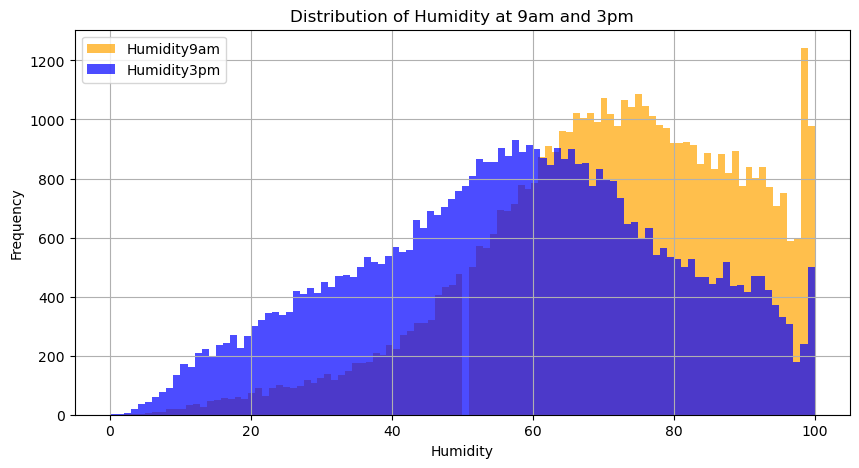

In [25]:
# Plotting the histogram for 'Humidity9am' and 'Humidity3pm'
plt.figure(figsize=(10, 5)) 
plt.hist(balanced_df['Humidity9am'], bins=100, color='orange', alpha=0.7, label='Humidity9am')  
plt.hist(balanced_df['Humidity3pm'], bins=100, color='blue', alpha=0.7, label='Humidity3pm') 

plt.title('Distribution of Humidity at 9am and 3pm') 
plt.xlabel('Humidity')  
plt.ylabel('Frequency')  
plt.legend() 
plt.grid(True)
plt.show()

In [26]:
bin_edges = [i for i in range(0, 101, 20)]

# Define the bin labels
bin_edges = [i for i in range(0, 101, 20)]

# Define the bin labels
bin_labels = [f'{i}-{i+20}' for i in range(0, 80, 20)] + ['>80']

balanced_df['Humidity9am_encoded'] = pd.cut(balanced_df['Humidity9am'], bins=bin_edges, labels=bin_labels, include_lowest=True)
balanced_df['Humidity3pm_encoded'] = pd.cut(balanced_df['Humidity3pm'], bins=bin_edges, labels=bin_labels, include_lowest=True)

balanced_df.drop(columns=['Humidity9am', 'Humidity3pm'], inplace=True)

print(balanced_df['Humidity9am_encoded'].value_counts())
print(balanced_df['Humidity3pm_encoded'].value_counts())


Humidity9am_encoded
60-80    19827
>80      16810
40-60    10144
20-40     2681
0-20       576
Name: count, dtype: int64
Humidity3pm_encoded
40-60    15539
60-80    14723
20-40     8830
>80       7968
0-20      2978
Name: count, dtype: int64


Now for the pressure fields:

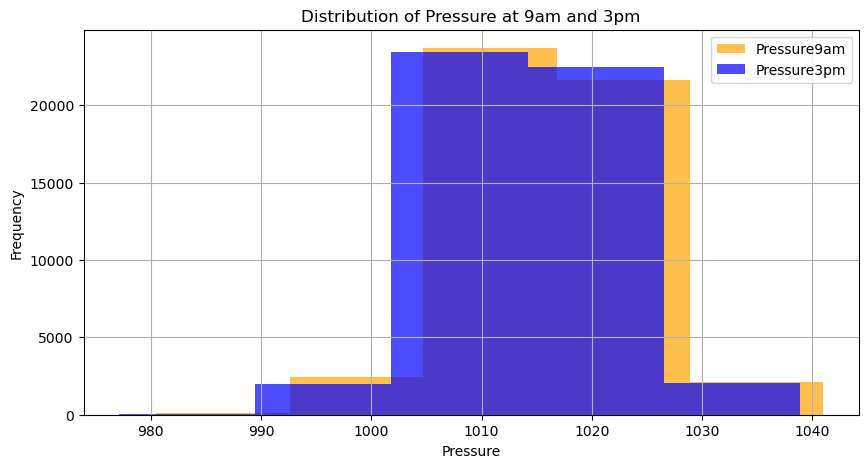

In [27]:
plt.figure(figsize=(10, 5))  
plt.hist(balanced_df['Pressure9am'], bins=len(bin_labels), color='orange', alpha=0.7, label='Pressure9am')  # Histogram for Pressure9am_encoded
plt.hist(balanced_df['Pressure3pm'], bins=len(bin_labels), color='blue', alpha=0.7, label='Pressure3pm')  # Histogram for Pressure3pm_encoded

plt.title('Distribution of Pressure at 9am and 3pm')  
plt.xlabel('Pressure') 
plt.ylabel('Frequency')  
plt.legend()  
plt.grid(True)
plt.show()

In [28]:
bin_edges = [0, 1000] + [i for i in range(1001, 1031, 10)] + [float('inf')]

# Define the bin labels
bin_labels = ['<1000'] + [f'{i}-{i+10}' for i in range(1001, 1030, 10)] + ['>1030']

balanced_df['Pressure9am'] = pd.cut(balanced_df['Pressure9am'], bins=bin_edges, labels=bin_labels, include_lowest=True)
balanced_df['Pressure3pm'] = pd.cut(balanced_df['Pressure3pm'], bins=bin_edges, labels=bin_labels, include_lowest=True)

print(balanced_df.head())

  Pressure9am Pressure3pm  RainToday  RainTomorrow MaxTemp_Categories  \
0   1011-1021   1011-1021          0             1              10-20   
1       >1030       >1030          1             1              10-20   
2       >1030       >1030          0             1              10-20   
3       >1030       >1030          0             0              20-30   
4       >1030   1021-1031          0             0              10-20   

  Rainfall_Categories WindGustSpeed_Category WindSpeed9am_Category  \
0                 0-5                 strong                medium   
1                 0-5                 strong                medium   
2                 0-5                 medium                   low   
3                 0-5                 medium                medium   
4                 0-5                 medium                   low   

  WindSpeed3pm_Category Humidity9am_encoded Humidity3pm_encoded  
0                medium               60-80               40-60  
1       

In [29]:
# Display the value counts of the new encoded columns
print("Value counts of Pressure9am:")
print(balanced_df['Pressure9am'].value_counts())

print("\nValue counts of Pressure3pm:")
print(balanced_df['Pressure3pm'].value_counts())

Value counts of Pressure9am:
Pressure9am
1021-1031    25876
>1030        12656
1011-1021    10431
<1000          858
1001-1011      217
Name: count, dtype: int64

Value counts of Pressure3pm:
Pressure3pm
1021-1031    24674
1011-1021    15621
>1030         8102
<1000         1302
1001-1011      339
Name: count, dtype: int64


In [30]:
balanced_df['RainToday'] = balanced_df['RainToday'].replace({1:'Yes', 0: 'No'})

### Now that the data is encoded, we will cleanup any potential naming artifacts from the feature names

In [31]:
balanced_df.columns = balanced_df.columns.str.replace('_encoded', '').str.replace('_Categories', '').str.replace('_Category', '')

In [32]:
balanced_df.head()

,Pressure9am,Pressure3pm,RainToday,RainTomorrow,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm
0,1011-1021,1011-1021,No,1,10-20,0-5,strong,medium,medium,60-80,40-60
1,>1030,>1030,Yes,1,10-20,0-5,strong,medium,medium,60-80,60-80
2,>1030,>1030,No,1,10-20,0-5,medium,low,low,>80,60-80
3,>1030,>1030,No,0,20-30,0-5,medium,medium,medium,60-80,40-60
4,>1030,1021-1031,No,0,10-20,0-5,medium,low,medium,60-80,60-80


## Bayesian Network Construction

Now that the data preparation phase is complete, we will experiment with different Bayesian Network configurations, and see how they perform.

### Basic model(all features are independent of each other)

In [33]:
bnmodel = BayesianNetwork([
    ('Pressure9am', 'RainTomorrow'),
    ('Pressure3pm', 'RainTomorrow'),
    ('RainToday', 'RainTomorrow'),
    ('MaxTemp', 'RainTomorrow'),
    ('Rainfall', 'RainTomorrow'),
    ('WindGustSpeed', 'RainTomorrow'),
    ('WindSpeed9am', 'RainTomorrow'),
    ('WindSpeed3pm', 'RainTomorrow'),
    ('Humidity9am', 'RainTomorrow'),
    ('Humidity3pm', 'RainTomorrow'),
    ('Humidity3pm', 'RainTomorrow')
])

# Print the structure of the Bayesian Network
print(bnmodel.edges())

[('Pressure9am', 'RainTomorrow'), ('Pressure3pm', 'RainTomorrow'), ('RainToday', 'RainTomorrow'), ('MaxTemp', 'RainTomorrow'), ('Rainfall', 'RainTomorrow'), ('WindGustSpeed', 'RainTomorrow'), ('WindSpeed9am', 'RainTomorrow'), ('WindSpeed3pm', 'RainTomorrow'), ('Humidity9am', 'RainTomorrow'), ('Humidity3pm', 'RainTomorrow')]


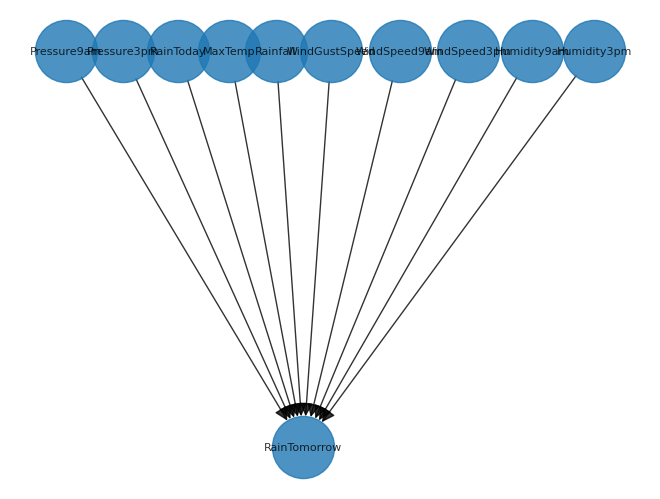

In [34]:
#plot the model:
pos = nx.nx_agraph.graphviz_layout(bnmodel, prog="dot")
nx.draw(bnmodel, pos, with_labels=True, node_size=2000,
        font_size=8, arrowsize=20, alpha=0.8)

Partitioning the data for the training of the model:

In [35]:
train_ratio = 0.75

train_size = int(balanced_df.shape[0] * train_ratio)

train_data = balanced_df[:train_size]
test_data = balanced_df[train_size:]

print(f"The shape of the training data is: {train_data.shape} and the shape of the test_data is: {test_data.shape}")

The shape of the training data is: (37528, 11) and the shape of the test_data is: (12510, 11)


Tthe Bayesian Estimator with a BDeu prior because it provides a more balanced and conservative approach to estimating the Conditional Probability Distributions (CPDs) in Bayesian networks. Unlike Maximum Likelihood Estimation, which can lead to overfitting by heavily relying on observed data, th  BDeu prior treats all outcomes nearly equally before seeing the data. This method enhances the model's generalizability and robustness, making it better suited for reliable prediction..l

In [36]:
start_time = time.time()

bnmodel.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

end_time = time.time()

duration = end_time - start_time
print(f"The fitting operation took {duration:.2f} seconds.")

The fitting operation took 47.20 seconds.


In [37]:
#test the network:
predict_data = test_data.drop('RainTomorrow', axis = 1)

label_prediction = test_data['RainTomorrow']

y_pred = bnmodel.predict(predict_data)

  0%|          | 0/3075 [00:00<?, ?it/s]

In [38]:
accuracy = accuracy_score(label_prediction, y_pred['RainTomorrow'])
print("Accuracy:", accuracy)

Accuracy: 0.7254996003197443


In [39]:
if(bnmodel.check_model()):
    print("The model is correctly defined")
else:
    print("The model presents imbalances")

The model is correctly defined


### For the next networks, we will strive to build networks with humanly understandable connections

At the same time, we will use the correlation matrix of the model to gain better insights about the model

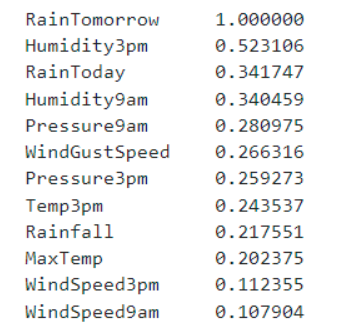

The next network will be designed with the following main logic in mind:
The state of the weather in the morning when combined with measurements about the state of the weather in the afternoon will give insights about the possible wheather of tommorow.
Furthermore, the following considerations were added:

1.The Humidity is dependable on the wind speed (source: https://www.researchgate.net/figure/Relative-humidity-RH-as-a-function-of-wind-speed-v-for-the-four-stations-all-data_fig3_241060910)

2.The pressure, hummidity and the temperature are correlated (source: https://www.researchgate.net/figure/A-Relationship-between-vapor-pressure-relative-humidity-and-temperature-The-relative_fig1_235364413)

In [40]:
bnmodel_understandable = BayesianNetwork([
    ('WindSpeed9am', 'WindSpeed3pm'), 
    ('WindSpeed9am', 'Humidity9am'),
    ('WindSpeed9am', 'Pressure9am'),
    ('WindGustSpeed', 'Pressure9am'),
    ('WindGustSpeed', 'MaxTemp'),
    ('WindGustSpeed', 'Rainfall'),
    ('WindSpeed3pm', 'RainToday'),
    ('WindSpeed3pm', 'Pressure3pm'),
    ('WindSpeed3pm', 'Humidity3pm'),
    ('Rainfall', 'MaxTemp'),
    ('Rainfall', 'RainToday'),
    ('Pressure9am', 'RainToday'),
    ('Pressure9am', 'Pressure3pm'),
    ('Humidity9am', 'MaxTemp'),
    ('Humidity9am', 'Humidity3pm'),
    ('Humidity3pm', 'RainTomorrow'),
    ('Pressure3pm', 'Humidity3pm'),
    ('Pressure3pm', 'RainTomorrow'),
    ('MaxTemp', 'RainToday'),
    ('MaxTemp', 'RainTomorrow'),
    ('RainToday', 'RainTomorrow'),
])
# Print the structure of the Bayesian Network
print(bnmodel_understandable.edges())

[('WindSpeed9am', 'WindSpeed3pm'), ('WindSpeed9am', 'Humidity9am'), ('WindSpeed9am', 'Pressure9am'), ('WindSpeed3pm', 'RainToday'), ('WindSpeed3pm', 'Pressure3pm'), ('WindSpeed3pm', 'Humidity3pm'), ('Humidity9am', 'MaxTemp'), ('Humidity9am', 'Humidity3pm'), ('Pressure9am', 'RainToday'), ('Pressure9am', 'Pressure3pm'), ('WindGustSpeed', 'Pressure9am'), ('WindGustSpeed', 'MaxTemp'), ('WindGustSpeed', 'Rainfall'), ('MaxTemp', 'RainToday'), ('MaxTemp', 'RainTomorrow'), ('Rainfall', 'MaxTemp'), ('Rainfall', 'RainToday'), ('RainToday', 'RainTomorrow'), ('Pressure3pm', 'Humidity3pm'), ('Pressure3pm', 'RainTomorrow'), ('Humidity3pm', 'RainTomorrow')]


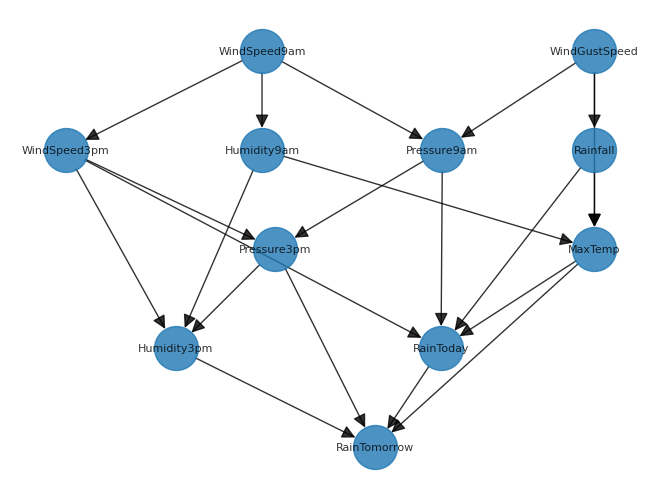

In [41]:
pos = nx.nx_agraph.graphviz_layout(bnmodel_understandable, prog="dot")
nx.draw(bnmodel_understandable, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

In [42]:
start_time = time.time()

bnmodel_understandable.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

end_time = time.time()

duration = end_time - start_time
print(f"The fitting operation took {duration:.2f} seconds.")

The fitting operation took 0.14 seconds.


In [43]:
#test the network:
predict_data = test_data.drop('RainTomorrow', axis = 1)

label_prediction = test_data['RainTomorrow']

y_pred = bnmodel_understandable.predict(predict_data)

  0%|          | 0/3075 [00:00<?, ?it/s]

In [44]:
accuracy = accuracy_score(label_prediction, y_pred['RainTomorrow'])
print("Accuracy:", accuracy)

Accuracy: 0.7550759392486012


In [45]:
if(bnmodel_understandable.check_model()):
    print("The model is correctly defined")
else:
    print("The model presents imbalances")

The model is correctly defined


Building our own network using domain experience has a few advantages:

1. The training time is shorter, when compared to the previous network
2. The accuracy is improved with 3%.
3. The new network has connections that are humanly understandable. This is especially important as we can greatly improve our network as we acquire more domain expertise.


### Trying a different approach

In the previous network, we used all the variables available in this image.
Next, we try to answer the following theory:
How important is deep inside knowledge for developing a baesian network, and, inherently, how robusts is this tool to modelling that does not capture the essence of the connections between data

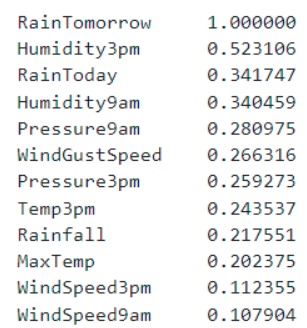


Theory: The data required(nr of features) to have good results in Bayesian Networks drastically decreases as we increase the domain knowledge that we use when we design our network.

To test this theory, we will try and build a simpler Bayesian Network.
Intuition: The RainTommorow category can be predicted based on the data that is measured at 3PM, ignoring the morning datapoints(As this information will be in part included in the 3PM measurement.). 

Furthermore, as the WindSpeed3pm measurement has a very low correlation with the predicted label, and the WindSpeed influences directly the Pressure and Humidity, we will discard the WindSpeed3pm measurement.

In this idea, we will use the following features: Humidity3pm, RainToday, WindGustSpeed, Pressure3pm, Temp3pm, Rainfall and MaxTemp.

### Adapting the dataset to the changes.

In [46]:
columns_to_drop = ['WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Humidity9am']
balanced_df = balanced_df.drop(columns=columns_to_drop, axis = 1)

train_ratio = 0.75

train_size = int(balanced_df.shape[0] * train_ratio)

train_data = balanced_df[:train_size]
test_data = balanced_df[train_size:]

print(f"The shape of the training data is: {train_data.shape} and the shape of the test_data is: {test_data.shape}")

The shape of the training data is: (37528, 7) and the shape of the test_data is: (12510, 7)


In [47]:
bnmodel_simplied = BayesianNetwork([
    ('WindGustSpeed', 'MaxTemp'),
    ('WindGustSpeed', 'Humidity3pm'),
    ('WindGustSpeed', 'Rainfall'),
    ('Rainfall', 'RainToday'),
    ('Pressure3pm', 'Rainfall'),
    ('Pressure3pm', 'Humidity3pm'),
    ('MaxTemp', 'RainToday'),
    ('RainToday', 'RainTomorrow'),
    ('Humidity3pm', 'RainTomorrow'),



])
print(bnmodel_simplied.edges())

[('WindGustSpeed', 'MaxTemp'), ('WindGustSpeed', 'Humidity3pm'), ('WindGustSpeed', 'Rainfall'), ('MaxTemp', 'RainToday'), ('Humidity3pm', 'RainTomorrow'), ('Rainfall', 'RainToday'), ('RainToday', 'RainTomorrow'), ('Pressure3pm', 'Rainfall'), ('Pressure3pm', 'Humidity3pm')]


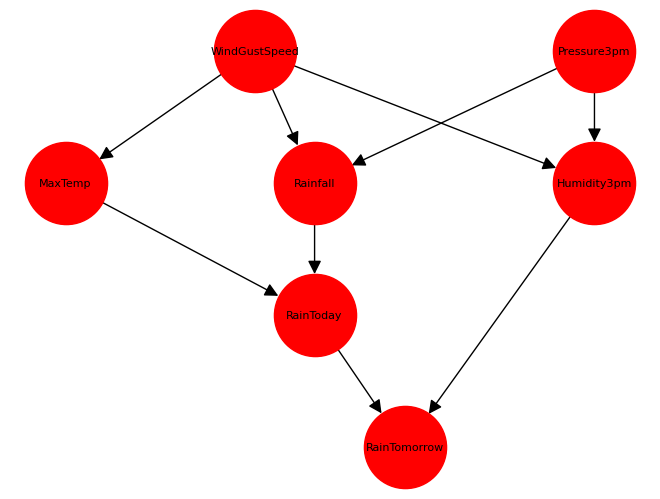

In [48]:
pos = nx.nx_agraph.graphviz_layout(bnmodel_simplied, prog="dot")
nx.draw(bnmodel_simplied, pos, with_labels=True, node_size=3500,
        font_size=8, arrowsize=20, alpha=1, node_color='red', font_color='black')

In [49]:
start_time = time.time()

bnmodel_simplied.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

end_time = time.time()

duration = end_time - start_time
print(f"The fitting operation took {duration:.2f} seconds.")

The fitting operation took 0.07 seconds.


In [50]:
#test the network:
predict_data = test_data.drop('RainTomorrow', axis = 1)

label_prediction = test_data['RainTomorrow']

y_pred = bnmodel_simplied.predict(predict_data)

  0%|          | 0/641 [00:00<?, ?it/s]

In [51]:
accuracy = accuracy_score(label_prediction, y_pred['RainTomorrow'])
print("Accuracy:", accuracy)

Accuracy: 0.7397282174260591


In [52]:
#Exploring the CPT's
for cpd in bnmodel_simplied.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print(cpd, '\n')

CPT of WindGustSpeed
+-----------------------+------------+
| WindGustSpeed(low)    | 0.00196272 |
+-----------------------+------------+
| WindGustSpeed(medium) | 0.809812   |
+-----------------------+------------+
| WindGustSpeed(strong) | 0.188225   |
+-----------------------+------------+ 

CPT of MaxTemp
+----------------+----------------------+-----------------------+-----------------------+
| WindGustSpeed  | WindGustSpeed(low)   | WindGustSpeed(medium) | WindGustSpeed(strong) |
+----------------+----------------------+-----------------------+-----------------------+
| MaxTemp(10-20) | 0.7511312217194571   | 0.352868924372697     | 0.46008304237048225   |
+----------------+----------------------+-----------------------+-----------------------+
| MaxTemp(20-30) | 0.19457013574660637  | 0.4606180908931392    | 0.3484004907049165    |
+----------------+----------------------+-----------------------+-----------------------+
| MaxTemp(30-40) | 0.004524886877828055 | 0.172968941919635

Previous network results: 75.5% accuracy, training time: The fitting operation took 0.16 seconds.

Current network results: accuracy: 74%, training time: 0.08 seconds.

DecisionTree accuracy: 76.5%.

Theory: 
The data required(nr of features) to have good results in Bayesian Networks drastically decreases as we increase the domain knowledge that we use when we design our network.

Conclusions:

Firstly, we remark that Bayesian networks are a powerful tool that is reliable when dealing with classification tasks. By comparing the results of the two networks (75.5% and 74% accuracy) performance with the performance of a DecisionTreeClassifier(76.5% accuracy) that was tunned via a GridSearchCV operation, the performance is comparable between the models. An important mention is that the DecisionTreeClasifier was trained on 16 features, while the first humanly understandable BN was trained on 11 features, and the last model was trained on 7 features. 


Secondly, we will address the mentioned theory.
Results:
1. Previous network results: 75.5% accuracy, training time: The fitting operation took 0.16 seconds.
2. Current network results: accuracy: 74%, training time: 0.08 seconds.
Decreasing the data by 36% (reducing the number of features from 11 features to 7 features) available to the model, the performance of the model drops by only 1.5%. Another mentionable benefit is that the training time is reduced to half (a trend that might replicate in very large datasets).

As these results were obtained by leveraging more and more insights about the system that we are trying to model, a reasonable conclusion would be that the theory appears to be true.

### Network Analysis


In [53]:
# Checking and printing the number of valid independence assertions in the model
total_independencies = len(bnmodel_simplied.get_independencies().get_assertions())
print(f"There can be made {total_independencies} valid independence assertions with respect to all possible given evidence.")

# Print local independencies: a node is independent of its non-descendants given its parents
local_indeps = bnmodel_simplied.local_independencies(balanced_df.columns.tolist())
print("For instance, any node in the network is independent of its non-descendants given its parents:")
print(f"\n{local_indeps}\n")


There can be made 137 valid independence assertions with respect to all possible given evidence.
For instance, any node in the network is independent of its non-descendants given its parents:

(Pressure3pm ⟂ WindGustSpeed, MaxTemp)
(RainToday ⟂ Pressure3pm, Humidity3pm, WindGustSpeed | Rainfall, MaxTemp)
(RainTomorrow ⟂ Pressure3pm, WindGustSpeed, Rainfall, MaxTemp | Humidity3pm, RainToday)
(MaxTemp ⟂ Pressure3pm, Humidity3pm, Rainfall | WindGustSpeed)
(Rainfall ⟂ Humidity3pm, MaxTemp | WindGustSpeed, Pressure3pm)
(WindGustSpeed ⟂ Pressure3pm)
(Humidity3pm ⟂ Rainfall, MaxTemp, RainToday | WindGustSpeed, Pressure3pm)



In [54]:
print('Next, we will analyze the the Markov Blanket of every node in this network.\n')


def markov_blanket(model, target_variable):
    return f"Markov blanket of \'{target_variable}\' is {bnmodel_simplied.get_markov_blanket(target_variable)}"


for column in balanced_df.columns:
    print(markov_blanket(bnmodel_simplied, column))

Next, we will analyze the the Markov Blanket of every node in this network.

Markov blanket of 'Pressure3pm' is ['Rainfall', 'Humidity3pm', 'WindGustSpeed']
Markov blanket of 'RainToday' is ['Humidity3pm', 'RainTomorrow', 'Rainfall', 'MaxTemp']
Markov blanket of 'RainTomorrow' is ['Humidity3pm', 'RainToday']
Markov blanket of 'MaxTemp' is ['WindGustSpeed', 'Rainfall', 'RainToday']
Markov blanket of 'Rainfall' is ['Pressure3pm', 'RainToday', 'WindGustSpeed', 'MaxTemp']
Markov blanket of 'WindGustSpeed' is ['Pressure3pm', 'Humidity3pm', 'Rainfall', 'MaxTemp']
Markov blanket of 'Humidity3pm' is ['Pressure3pm', 'RainTomorrow', 'WindGustSpeed', 'RainToday']


### Predicting if it will rain based on given evidence


In [55]:
def prediction(model, query):
    inference = VariableElimination(model)
    # Perform inference to get the probability distribution for 'RainTomorrow' given the evidence
    base_result = inference.query(variables=['RainTomorrow'], evidence=query)
    # Get the probability of 'RainTomorrow' being 'Yes'
    probs = np.round(base_result.values, 2)
    # Display the probability of rain tomorrow
    print(f'The probability of rain tomorrow is {probs[1]*100}%')

In [56]:
evidence1 = {
    'Pressure3pm': '1021-1031',  # High pressure
    'WindGustSpeed': 'medium'    # Medium wind gust speed
}
prediction(bnmodel_simplied, evidence1)

The probability of rain tomorrow is 48.0%


In [57]:
evidence2 = {
    'Pressure3pm': '1001-1011',  # Low pressure
    'WindGustSpeed': 'strong',   # Strong wind gust speed
    'MaxTemp': '30-40'           # High temperature range
}
prediction(bnmodel_simplied, evidence2)

The probability of rain tomorrow is 56.99999999999999%


In [58]:
evidence3 = {
    'Pressure3pm': '<1000',      # Very low pressure
    'WindGustSpeed': 'low'       # Low wind gust speed
}
prediction(bnmodel_simplied, evidence3)

The probability of rain tomorrow is 55.00000000000001%


In [59]:
evidence4 = {
    'Pressure3pm': '>1030',      # Very high pressure
    'WindGustSpeed': 'low',      # Low wind gust speed
    'RainToday': 'No'            # No rain today
}
prediction(bnmodel_simplied, evidence4)

The probability of rain tomorrow is 49.0%


### Next we will build an interface to make predicting for a new datapoint easier

In [60]:
def prediction(model, query):
    inference = VariableElimination(model)
    try:
        result = inference.query(variables=['RainTomorrow'], evidence=query) 
        probability = result.values[1]  
        return probability
    except Exception as e:
        print(f"Error during model inference: {str(e)}")
        return None

def BeliefPrediction(pressure, wind_gust_speed, max_temp, humidity, rainfall, rain_today):
    evidence = {
        'Pressure3pm': pressure,
        'WindGustSpeed': wind_gust_speed,
        'MaxTemp': max_temp,
        'Humidity3pm': humidity,
        'Rainfall': rainfall,
        'RainToday': rain_today
    }
    # Use the prediction function to get the probability as a percentage
    probability = prediction(bnmodel_simplied, evidence)  
    
    # Convert probability to percentage
    percentage = probability * 100
    
    # Generate a qualitative description based on the probability
    if probability >= 0.8:
        description = "Very likely to rain tomorrow."
    elif probability >= 0.6:
        description = "Likely to rain tomorrow."
    elif probability >= 0.4:
        description = "Possible chance of rain tomorrow."
    elif probability >= 0.2:
        description = "Unlikely to rain tomorrow."
    else:
        description = "Very unlikely to rain tomorrow."
    
    return f"The probability of rain tomorrow is {percentage:.2f}%. {description}"


In [61]:
demo = gr.Interface(
    fn=BeliefPrediction,
    inputs=[
        gr.Dropdown(choices=['<1000', '1001-1011', '1011-1021', '1021-1031', '>1030'], label="Pressure3pm"),
        gr.Dropdown(choices=['low', 'medium', 'strong'], label="WindGustSpeed"),
        gr.Dropdown(choices=['<10', '10-20', '20-30', '30-40', '>40'], label="MaxTemp"),
        gr.Dropdown(choices=['0-20', '20-40', '40-60', '60-80', '>80'], label="Humidity3pm"),
        gr.Dropdown(choices=['0-5', '5-10', '10-15', '15-20', '20-21', '21-31', '31-41', '>40'], label="Rainfall"),
        gr.Dropdown(choices=['No', 'Yes'], label="RainToday")
    ],
    outputs=[gr.Textbox(label="Prediction")],
    title="Rain Tomorrow Prediction",
    description="This application predicts the probability of rain tomorrow based on current weather conditions, providing both a percentage likelihood and a qualitative description."
)

demo.launch()


Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"



To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
INFO:httpx:HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-launched-telemetry/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-initiated-analytics/ "HTTP/1.1 200 OK"
